In [18]:
!nvidia-smi

Sun May 16 00:18:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    41W / 300W |  10061MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [19]:
!pip install transformers datasets

In [20]:
import sklearn
import nltk
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from datasets import list_metrics, load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, \
                            Trainer, TrainingArguments


Load data

In [21]:
country = 'PT'
dataset = country+'_data_100k'
df = pd.read_parquet('drive/MyDrive/data/EU_motors_data/'+country+'/'+dataset+'.parquet')
df.head()

,price_eval_sk,prediction,lower,higher,target_price,error,ape,pe,range_size_pct,set,description,is_business,string_features,error_type
0,8082568918|PT|standvirtual,9675.700195,9188.767773,10162.632617,10999.0,-1323.299805,12.031092,-12.031092,10.065058,active,Viatura com histórico geral e livro de revisoe...,1.0,"make is vw, model is tiguan, vehicle_year is 2...",0
1,8080279702|PT|standvirtual,15045.987305,14288.793945,15803.180664,17712.0,-2666.012695,15.052014,-15.052014,10.065054,train,Opel Insignia Sport Tourer 1.6 Cdti Selection ...,1.0,"make is opel, model is insignia-sports-tourer,...",0
2,8081130761|PT|standvirtual,13085.506836,12426.975586,13744.038086,14500.0,-1414.493164,9.755125,-9.755125,10.065047,train,Veículo Nacional comprado novo com todos as re...,0.0,"make is volvo, model is v40-cross-country, veh...",0
3,8082746155|PT|standvirtual,6840.919434,6496.648438,7185.190430,4999.0,1841.919434,36.845758,36.845758,10.065050,train,viatura proveniente de retoma\r\ngarantia de a...,1.0,"make is lancia, model is musa, vehicle_year is...",1
4,8082544106|PT|standvirtual,13431.394531,12755.456055,14107.333008,13500.0,-68.605469,0.508189,-0.508189,10.065053,train,"Toyota: Usados de Confiança. Mais Segurança, M...",1.0,"make is toyota, model is yaris, vehicle_year i...",0


In [22]:
df['description'].iloc[2]

'Veículo Nacional comprado novo com todos as revisões e serviços efetuados na marca. Kms na sua quase totalidade feitos em auto estrada, sendo o motivo da venda necessidade de veículo maior com capacidade entre 7 a 9 lugares podendo aceitar retoma ou troca com essas características pagando a diferença.'

In [23]:
df['string_features_plus_description'] = df[['string_features', 
                                             'description']].apply(lambda row: ', '.join([row[0], row[1]]), axis=1)

In [24]:
problem_type = 'regression'

In [25]:
model_name = 'neuralmind/bert-base-portuguese-cased'
#model_name = 'bert-base-cased' # For price prediction using string features
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)


Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

### Define target and input features, filter outliers and split data in train/validation and test sets

In [26]:
target = 'target_price'
#target = 'pe'
regressor = 'string_features'
#regressor = 'string_features_plus_description'
#regressor = 'description'

num_ads_in_sample = len(df)
df_sample = df.sample(num_ads_in_sample)
df_sample.dropna(subset=[regressor, target], inplace=True)

#remove outliers
lower_quantile = df_sample[target].quantile(0.01)
higher_quantile = df_sample[target].quantile(0.99)

df_sample = df_sample[np.logical_and(df_sample[target] >= lower_quantile,  
                                     df_sample[target] <= higher_quantile)]


## Split into train and validation
train, valid, test = np.split(df_sample.sample(frac=1, random_state=42),
        [int(.7 * len(df_sample)), int(.9 * len(df_sample))])

Text(0.5, 0, 'target_price')

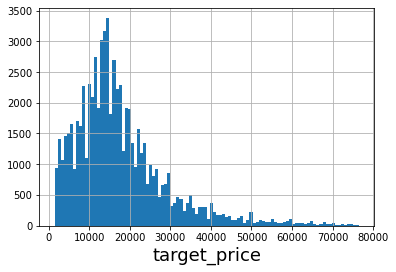

In [27]:
train[target].hist(bins=100)
plt.xlabel(target, fontsize=18)

In [28]:
## Let's save our descriptions and labels into lists
train_descs, train_labels = train[regressor].tolist(), train[target].tolist()
valid_descs, valid_labels = valid[regressor].tolist(), valid[target].tolist()
test_descs, test_labels = test[regressor].tolist(), test[target].tolist()

## And encode with tokenizer
MAX_LENGTH = 128
train_encodings = tokenizer(train_descs, truncation=True, padding='max_length', max_length=MAX_LENGTH)
val_encodings = tokenizer(valid_descs, truncation=True, padding='max_length', max_length=MAX_LENGTH)
test_encodings = tokenizer(test_descs, truncation=True, padding='max_length', max_length=MAX_LENGTH)

In [29]:
print(tokenizer.convert_ids_to_tokens(train_encodings['input_ids'][170]))
print(train_labels[0])

['[CLS]', 'ma', '##ke', 'is', 'to', '##yo', '##ta', ',', 'model', 'is', 'y', '##ari', '##s', ',', 've', '##hi', '##cle', '_', 'y', '##e', '##ar', 'is', '2006', '.', '0', ',', 'mil', '##e', '##age', 'is', '165', '##000', '.', '0', ',', 'eng', '##ine', '_', 'capaci', '##ty', 'is', '1000', '.', '0', ',', 'eng', '##ine', '_', 'po', '##wer', 'is', '70', '.', '0', ',', 'ge', '##ar', '##box', 'is', 'manual', ',', 'fu', '##el', '_', 't', '##y', '##pe', 'is', 'ga', '##z', ',', 'dama', '##ge', '##d', 'is', '0', '.', '0', ',', 'is', '_', 'bus', '##iness', 'is', '1', '.', '0', ',', 'r', '##h', '##d', 'is', '0', '.', '0', ',', 'ac', '##ry', '##lic', 'is', 'na', '##n', ',', 'bo', '##dy', '_', 't', '##y', '##pe', 'is', 'ci', '##ty', '-', 'car', ',', 'color', 'is', 'bl', '##ac', '##k', ',', 'country', '_', 'orig', '##in', 'is', 'No', '[SEP]']
15500.0


### Define a custom Dataset class, add max value seen in training as normalization constant

In [30]:
class RegressionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels, max_label):
        self.encodings = encodings
        self.max_value = max_label # keep track of normalization constant to be able to rescale values later
        labels /= self.max_value # normalize target, based on max value in train set
        labels = torch.tensor(labels, dtype=torch.float)
        self.labels = torch.reshape(labels, [len(labels), 1] )
        

    def __getitem__(self, idx):
        
        # Encodings are dictionaries that include list of lists for the keys: 
        # 'input_ids', 'attention_mask', 'token_type_ids'
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


In [31]:
max_train_price = np.max(train_labels) 
print(max_train_price)

train_dataset = RegressionDataset(train_encodings, train_labels, max_train_price)
val_dataset = RegressionDataset(val_encodings, valid_labels, max_train_price)
test_dataset = RegressionDataset(test_encodings, test_labels, max_train_price)

76500.0


In [32]:
#BertForSequenceClassification.forward?

## Fine-tuning the model
The Trainer class streamlines the training process and provides useful abstractions for quickly customize the training. Custom metrics asre defined for the regression problem.


## Training Arguments¶



In [33]:
training_args = TrainingArguments(
        output_dir="./results",            
        evaluation_strategy="epoch",   
        logging_steps=100,
        num_train_epochs=4,                
        per_device_train_batch_size=64,    
        per_device_eval_batch_size=64,     
        learning_rate=5e-05,                
        max_grad_norm=1.0,                 
        lr_scheduler_type='cosine_with_restarts',           
        warmup_steps=100,               
        load_best_model_at_end=True,
        metric_for_best_model='mse',
        seed=42
    )

def compute_metrics(eval_pred):
    # Evaluation will return a tuple of (predictions and labels). Predictions will be the logit values.
    predictions, labels = eval_pred
    
    # We argmax the prediction array to get the predicted classes
    mse = np.mean((predictions - labels)**2)
    rmse = mse**0.5
    r_squared = sklearn.metrics.r2_score(predictions, labels)
    mdape = np.median((np.abs((predictions - labels) / labels)) *100) 

    return {'mse': mse, 'rmse':rmse, 'r_squared':r_squared, 'mdape':mdape}

trainer = Trainer(
model=model,         
args=training_args,                  
train_dataset=train_dataset,
eval_dataset=val_dataset,
compute_metrics=compute_metrics,
tokenizer=tokenizer
)

In [34]:
trainer.train()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Mse,Rmse,R Squared,Mdape
1,0.002800,0.002085,0.002085,0.045660,0.891269,10.046137
2,0.001800,0.001519,0.001519,0.038971,0.935293,8.082722
3,0.001500,0.001407,0.001407,0.037512,0.943555,8.609577
4,0.001200,0.001409,0.001409,0.037543,0.945497,8.494379


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


TrainOutput(global_step=4292, training_loss=0.0026965654539317587, metrics={'train_runtime': 2906.0138, 'train_samples_per_second': 1.477, 'total_flos': 0, 'epoch': 4.0, 'init_mem_cpu_alloc_delta': 8192, 'init_mem_gpu_alloc_delta': 436447744, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': -481972224, 'train_mem_gpu_alloc_delta': 1313217024, 'train_mem_cpu_peaked_delta': 483774464, 'train_mem_gpu_peaked_delta': 7108658176})

### Evaluate model on test set and visualize results

In [35]:
trainer.evaluate(test_dataset)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


{'epoch': 4.0,
 'eval_loss': 0.0018949030200019479,
 'eval_mdape': 10.11136531829834,
 'eval_mem_cpu_alloc_delta': 274432,
 'eval_mem_cpu_peaked_delta': 0,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_gpu_peaked_delta': 277172736,
 'eval_mse': 0.0018949030200019479,
 'eval_r_squared': 0.8976376893045301,
 'eval_rmse': 0.043530483801606755,
 'eval_runtime': 26.4928,
 'eval_samples_per_second': 370.138}

In [ ]:
res = trainer.predict(test_dataset)

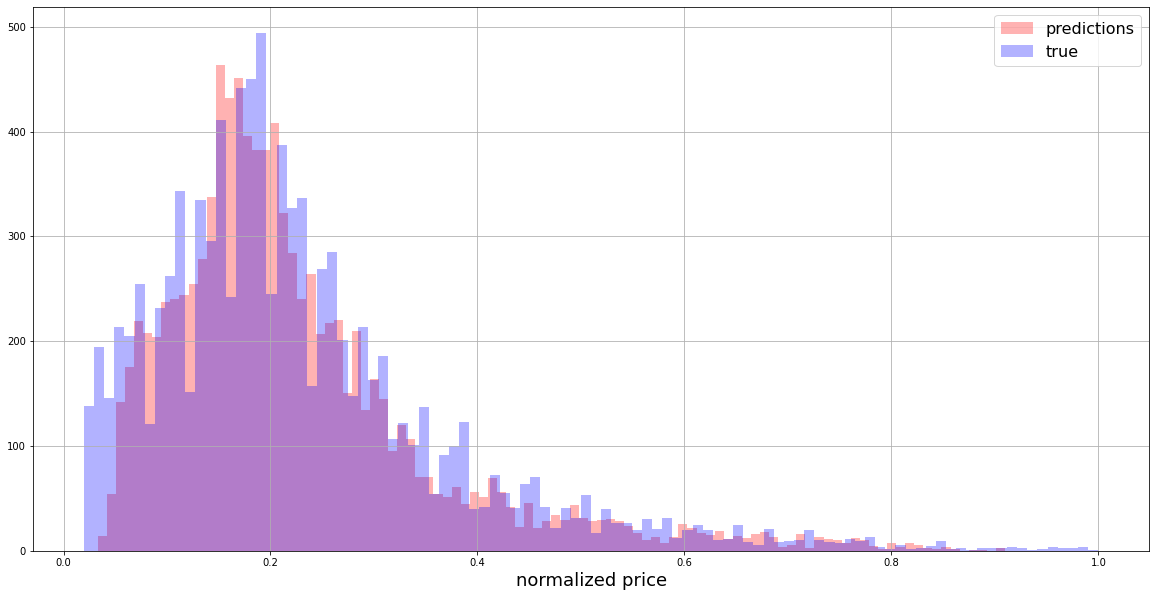

In [37]:
plt.figure(figsize=(20,10))
plt.hist(res.predictions, color='r', alpha=0.3, label='predictions', bins=100)
plt.hist(res.label_ids, color='b', alpha=0.3, label='true', bins=100)
plt.legend(fontsize=16)
plt.grid()
plt.xlabel('normalized price', fontsize=18)
plt.show()

In [ ]:
from matplotlib import pyplot as plt

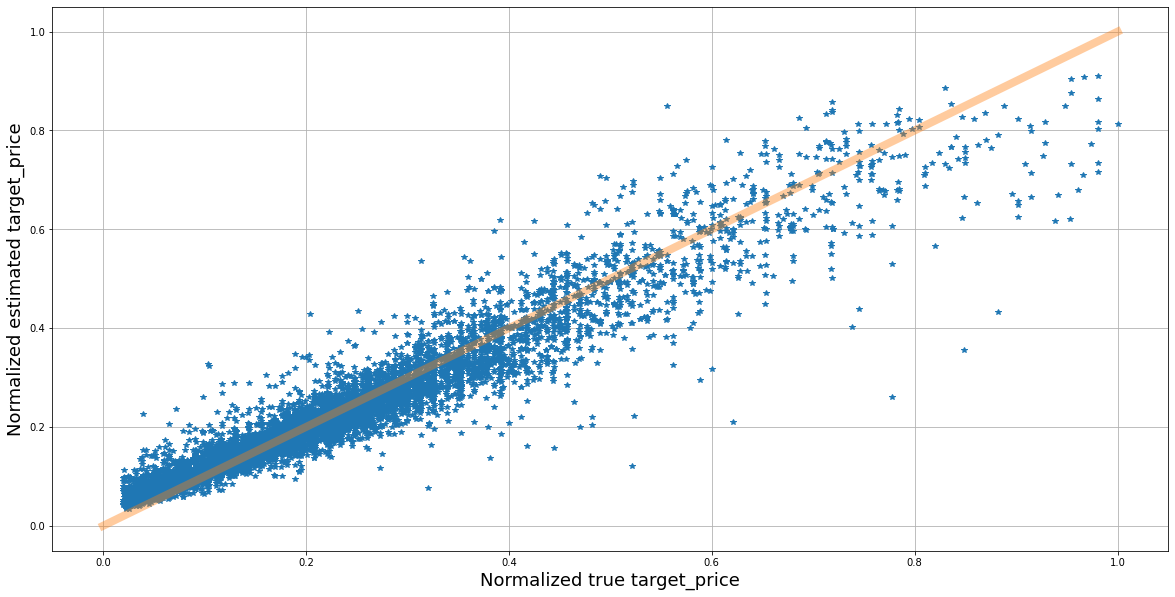

In [48]:
plt.figure(figsize=(20,10))
plt.plot(res.label_ids, res.predictions,  '*')
plt.xlabel('Normalized true ' + target, fontsize=18)
plt.ylabel('Normalized estimated ' + target, fontsize=18)
plt.grid()

plt.plot([0, 1], [0, 1], linewidth=8, alpha=0.4)
plt.show()


In [40]:
res_df = pd.DataFrame(data = {'true':res.label_ids.squeeze()*train_dataset.max_value, 
                              'predicted':res.predictions.squeeze()*train_dataset.max_value,
                              'string_features':test.string_features}, index=test.index)

In [41]:
res_df['error'] = res_df['true'] - res_df['predicted']
res_df['abs_error'] = np.abs(res_df['error'] )
res_df['ape'] = np.abs(res_df['abs_error'] / res_df['true']) * 100
res_df.describe()

,true,predicted,error,abs_error,ape
count,9806.000000,9806.000000,9806.000000,9806.000000,9806.000000
mean,17534.732422,17418.824219,115.758797,2193.081543,18.239491
std,11378.997070,10408.954102,3328.236816,2506.098145,29.484737
min,1500.000000,2534.164307,-22468.046875,0.017578,0.000208
25%,9990.000000,10977.935547,-1543.817871,700.467285,4.631221
50%,14990.000000,14936.462891,-151.525146,1503.379883,10.111364
75%,21900.000000,20981.541504,1448.256592,2764.322021,19.107708
max,76500.000000,69595.359375,39539.679688,39539.679688,478.142212


Text(0.5, 0, 'Absolute percentage error')

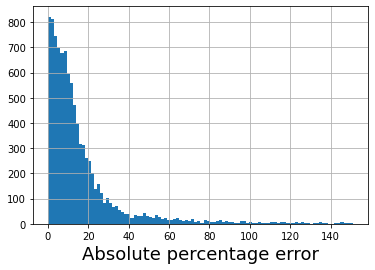

In [42]:
res_df['ape'].hist(bins=100, range=( res_df['ape'].quantile(0.01), res_df['ape'].quantile(0.99) ))
plt.xlabel('Absolute percentage error', fontsize=18)

In [43]:
MODEL_SAVE_PATH = 'drive/MyDrive/models/EU_motors_data/pt/PT_test_model'

In [44]:
# First extract the trained model from the trainer
pt_model = trainer.model

# Then save it
torch.save(pt_model, MODEL_SAVE_PATH)

In [45]:
model = torch.load(MODEL_SAVE_PATH)

### Test model behavior.

In [46]:
def get_price_estimate(text, tokenizer, model, norm_const):

    # Tokenize your text
    device = 'cuda:0'
    inputs = tokenizer(text, max_length=128,  padding='max_length', return_tensors='pt').to(device)

    # Get the prediction
    output = model(**inputs)
    with torch.no_grad():
        print('The predicted price is: {}'.format(output.logits.cpu().numpy()*norm_const))

In [47]:
text = ['make is renault, model is clio, vehicle_year is 2016.0, mileage is 36000.0, engine_capacity is 898.0']

get_price_estimate(text, tokenizer, model, train_dataset.max_value)

The predicted price is: [[16104.416]]
